<div style="color: #188193;
            font-weight: bold;
            padding: 20px 5px 20px 0px;
            border: 3px solid #188193;
            text-align: center">
    <span style="font-size: 35px">Titanic Competition Step by Step Using XGBoost</span><br>
</div>

<h1 id="introduction"
     style="color: white;
            font-size: 28px;
            font-weight: bold;
            border-radius: 5px;
            background-color: #188193;
            border-bottom: 4px solid black;
            padding: 17px 0px 17px 30px;
            margin-top:20px">
    1. Introduction
    <a class="anchor-link"
       href="#introduction"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

This notebook implements an XGBoost model to predict the likelihood of survival for passengers aboard the Titanic using information provided in the Kaggle.com Titanic competition dataset.

<h1 id="Dataset"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;1.1. Dataset
    <a class="anchor-link"
       href="#Dataset"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

The Titanic dataset was obtained from the Kaggle Titanic - Machine Learning from Disaster competition. [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/overview)

<h1 id="Context"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;1.2. Context
    <a class="anchor-link"
       href="#Context"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Quoting "The Challenge" as described on the Kaggle Titanic competition page:

- On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.
- While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.
- In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (i.e., name, age, gender, socio-economic class, etc).

<h1 id="Note_to_Readers"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;1.3. Note to Readers
    <a class="anchor-link"
       href="#Note_to_Readers"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

I created this notebook as an attempt to approach the Titanic Problem in a step-by-step way that would be helpful for beginners. I hope that those who review this notebook will be generous with their comments, criticisms, and advice, both positive and negative. <br>
Thank you for your time, and I wish you all the best!

**IF YOU WOULD LIKE TO LEARN HOW TO MAKE A MULTI-LEVEL TABLE OF CONTENTS LIKE THE ON IN THIS NOTEBOOK** [**CHECK IT OUT HERE**](https://www.kaggle.com/code/wissams/multi-level-table-of-contents-in-a-notebook)

<h1 id="Import_Necessary_Libraries_and_Load_Data"
     style="color: white;
            font-size: 28px;
            font-weight: bold;
            border-radius: 5px;
            background-color: #188193;
            border-bottom: 4px solid black;
            padding: 17px 0px 17px 30px;
            margin-top:20px">
    2. Import Necessary Libraries and Load Data
    <a class="anchor-link"
       href="#Import_Necessary_Libraries_and_Load_Data"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

plt.style.use('ggplot')
pd.set_option('display.max_columns', False)
seed= 92

loading train and test data into dataframes:

In [87]:
train= pd.read_csv('s3://retail-mlops-edu-202602/input/train.csv')
test= pd.read_csv('s3://retail-mlops-edu-202602/input/test.csv')

<h1 id="Exploratory_Data_Analysis"
     style="color: white;
            font-size: 28px;
            font-weight: bold;
            border-radius: 5px;
            background-color: #188193;
            border-bottom: 4px solid black;
            padding: 17px 0px 17px 30px;
            margin-top:20px">
    3. Exploratory Data Analysis
    <a class="anchor-link"
       href="#Exploratory_Data_Analysis"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Exploratory Data Analysis (EDA) is an essential step in the data analysis process, which involves examining the data to gain insights and understand its structure and content. In this step, we typically check for duplicates, assess the shape of the data, and identify any initial patterns or trends. EDA helps us get a basic understanding of the data and lays the foundation for further analysis and modeling, so let's do it:

In [6]:
#Combining train and test
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)

#Duplicates and shapes
print(F"Number of duplicate rows: {len(all_data.drop('Survived', axis=1))-len(all_data.drop('Survived', axis=1).drop_duplicates())}")
print(f"Shape of train:    {train.shape}")
print(f"Shape of test:     {test.shape}")
print(f"Shape of all_data: {all_data.shape}")

Number of duplicate rows: 0
Shape of train:    (712, 12)
Shape of test:     (179, 12)
Shape of all_data: (891, 12)


`.info()` provides usefull information including names of columns and datatypes:

In [7]:
print('#TRAIN INFO:')
print(train.info(),'\n')
print('#TEST INFO:')
print(test.info())

#TRAIN INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          575 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        160 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.9+ KB
None 

#TEST INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  179 n

- Training data has 12 columns, 11 variables and the label column "Survived'.
- Test data has 11 columns, columns "Survived" is not present as it is what we need to predict.

let's explore the columns one by one:

<h1 id="PassengerID"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;3.1. PassengerID
    <a class="anchor-link"
       href="#PassengerID"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

The identifier column with a datatype of int64. There are no dupicates as shown below.

In [8]:
print(F"Number of duplicates in PassengerId column = {len(all_data)-len(pd.unique(all_data['PassengerId']))}")

Number of duplicates in PassengerId column = 0


<h1 id="Survived"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;3.2. Survived
    <a class="anchor-link"
       href="#Survived"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

The label column, with a datatype of int64, it has two values: 0 represents passengers who did not survive, and 1 represents those who did. Among the 891 passengers in the training set, 61.6% survived and 38.4% did not.

In [9]:
print("Value count")
print(train['Survived'].value_counts())
print("\nRatio")
print(train['Survived'].value_counts(normalize= True))

Value count
Survived
0    439
1    273
Name: count, dtype: int64

Ratio
Survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64


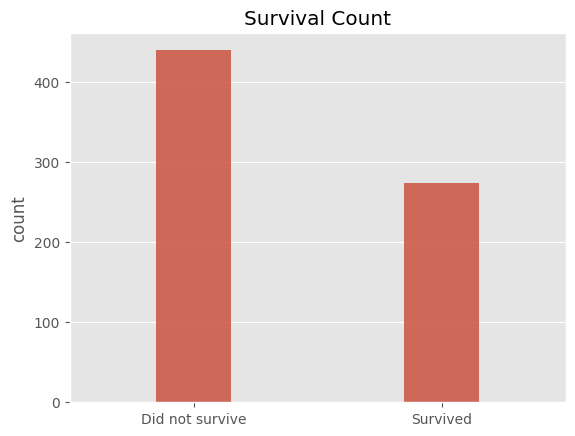

In [10]:
sns.countplot(data=train, x='Survived', width= 0.3, alpha= 0.9)
plt.xticks(ticks=[0, 1], labels=['Did not survive', 'Survived'])
plt.title("Survival Count")
plt.xlabel("")
plt.show()

<h1 id="Pclass"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;3.3. Pclass
    <a class="anchor-link"
       href="#Pclass"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Refers to Passenger class with a datatype of int64, where 1 represents 1st class, 2 represents 2nd class, and 3 represents 3rd class. It is notable that the survival percentage in the 1st class is the highest.

In [11]:
pclass_pivot = train.pivot_table(index='Pclass', columns='Survived', values='PassengerId', aggfunc='count')
pclass_pivot.columns = ['No', 'Yes']
pclass_pivot['Total'] = pclass_pivot['Yes'] + pclass_pivot['No']
pclass_pivot['Survival %'] = round(pclass_pivot['Yes'] / (pclass_pivot['Yes'] + pclass_pivot['No']) * 100,1).astype(str) + '%'
pclass_pivot

,No,Yes,Total,Survival %
Pclass,,,,
1,60,111,171,64.9%
2,83,67,150,44.7%
3,296,95,391,24.3%


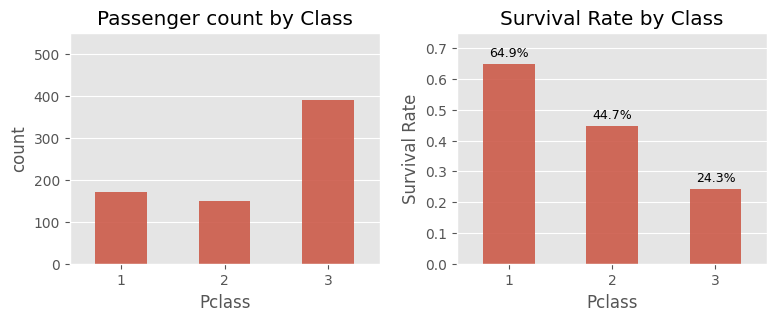

In [12]:
fig= plt.figure(figsize=(9,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Pclass", data=train, width= 0.5, alpha= 0.9, ax=ax1)
ax1.set_title("Passenger count by Class")
ax1.set_ylim([0, 550])


ax2= plt.subplot(1,2,2)
pclass_survival_rate = train.groupby('Pclass')['Survived'].mean().reset_index()
sns.barplot(x='Pclass', y='Survived', data=pclass_survival_rate,  alpha= 0.9, width= 0.5, ax= ax2)
ax2.set_title('Survival Rate by Class')
ax2.set_xlabel('Pclass')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.75])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.25)
plt.show()

<h1 id="Name"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;3.4. Name
    <a class="anchor-link"
       href="#Name"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

This column includes the names of the passengers and their titles. The datatype is object. Upon inspection, there are two duplicate names in the dataset, you can see below that the duplicates have different ages and tickets, so we will assume that they are different people who happen to have the same name by chance.

In [13]:
print(F"Number of duplicates in Name column = {len(all_data)-len(pd.unique(all_data['Name']))}")

Number of duplicates in Name column = 0


In [14]:
all_data[all_data.duplicated(subset='Name', keep=False)].sort_values('Name')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


<h1 id="Sex"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;3.5. Sex
    <a class="anchor-link"
       href="#Sex"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

This column indicates the sex of the passenger, with a datatype of object and values of either male or female. In our training data, we have 577 males and 314 females. Notably, being a female is good predictive of survival as 74.2% of women survived while only 18.9% of men survived.

In [15]:
sex_pivot = train.pivot_table(index='Sex', columns='Survived', values='PassengerId', aggfunc='count', fill_value= 0)
sex_pivot.columns = ['No', 'Yes']
sex_pivot['Total'] = sex_pivot.sum(axis=1)
sex_pivot['Survival %'] = round(sex_pivot['Yes'] / sex_pivot['Total']  * 100,1).astype(str) + '%'
sex_pivot

,No,Yes,Total,Survival %
Sex,,,,
female,65,188,253,74.3%
male,374,85,459,18.5%


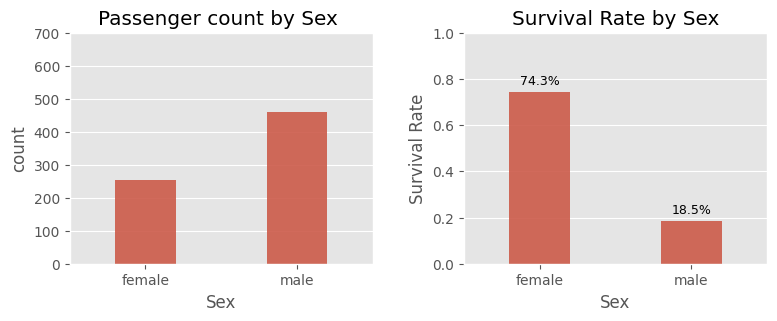

In [16]:
fig= plt.figure(figsize=(9,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Sex", data=train, width= 0.4, alpha= 0.9, order=['female', 'male'], ax=ax1)
ax1.set_title("Passenger count by Sex ")
ax1.set_ylim([0, 700])


ax2= plt.subplot(1,2,2)
sex_survival_rate = train.groupby('Sex')['Survived'].mean().reset_index()
sns.barplot(x='Sex', y='Survived', data=sex_survival_rate,  alpha= 0.9, width= 0.4, ax= ax2)
ax2.set_title('Survival Rate by Sex')
ax2.set_xlabel('Sex')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 1])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.3)
plt.show()

<h1 id="Age"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;3.6. Age
    <a class="anchor-link"
       href="#Age"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Passenger age, datatype float64.  Let's examine the age distribution in both the train and test datasets. The two histogrom plots in the first line below indicate that the distribution of age in both train and test datasets is comparable, and the kernal density plot (kde) below confirm that. However, when we look at the boxplot of age by survival status, we can see that the age distributions for both the "survived" and "did not survive" groups appear similar. This suggests that age, on it's own, may not be a strong predictor for survival.

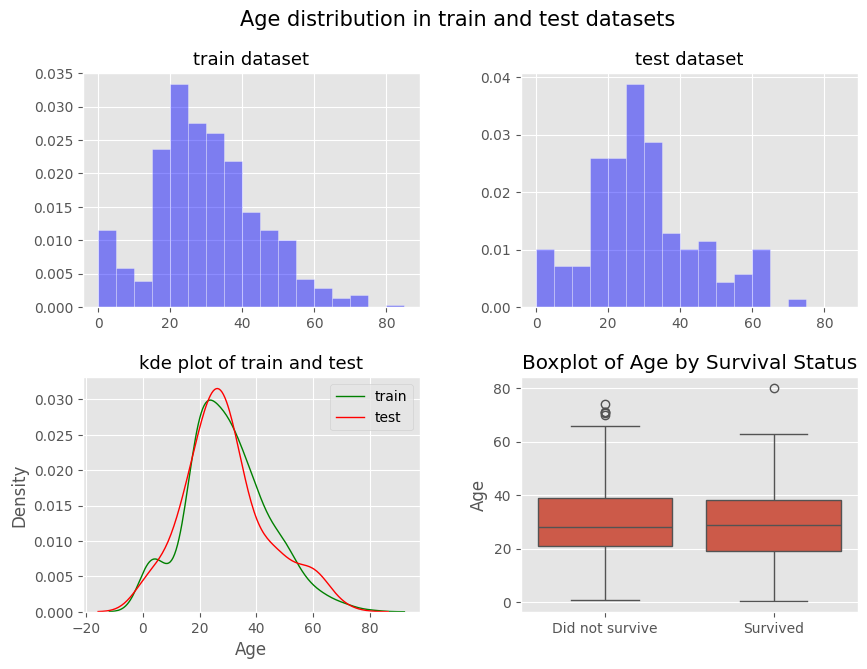

In [17]:
fig = plt.figure(figsize=(10, 7))

ax1 = plt.subplot(2, 2, 1)
count, bin_edges = np.histogram(train['Age'].dropna(), bins=range(0, 90, 5))
ax1.hist(train['Age'].dropna(), bins=bin_edges, alpha= 0.45, density=True, color='blue', edgecolor='white')
ax1.set_title('train dataset', fontsize=13)

ax2 = plt.subplot(2, 2, 2)
count, bin_edges = np.histogram(test['Age'].dropna(), bins=range(0, 90, 5))
ax2.hist(test['Age'].dropna(), bins=bin_edges, alpha= 0.45, density=True, color='blue', edgecolor='white')
ax2.set_title('test dataset', fontsize=13)

ax3 = plt.subplot(2, 2, 3)
sns.kdeplot(data=train, x='Age', color='green', label='train', linewidth= 1, ax=ax3)
sns.kdeplot(data=test, x='Age', color='red', label='test', linewidth= 1, ax=ax3)
plt.legend()
ax3.set_title('kde plot of train and test', fontsize=13)

ax4 = plt.subplot(2, 2, 4)
sns.boxplot(data=train.dropna(subset=['Age']), y="Age", x="Survived", ax=ax4)
ax4.set_xticks([0, 1], ['Did not survive', 'Survived'])
ax4.set_title("Boxplot of Age by Survival Status")
ax4.set_xlabel("")

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.suptitle('Age distribution in train and test datasets', y=0.97, fontsize=15)

plt.show()

<h1 id="SibSp"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;3.7. SibSp
    <a class="anchor-link"
       href="#SibSp"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Represents the number of siblings and spouses a passenger had aboard. Its datatype is int64. We can see in the plot below that the majority of passengers didn't have siblings or spouses aboard, and those who had one or two SibSp have the highest survival rate, we also can see that none of the passengers with 5 or 6 SibSp survived.

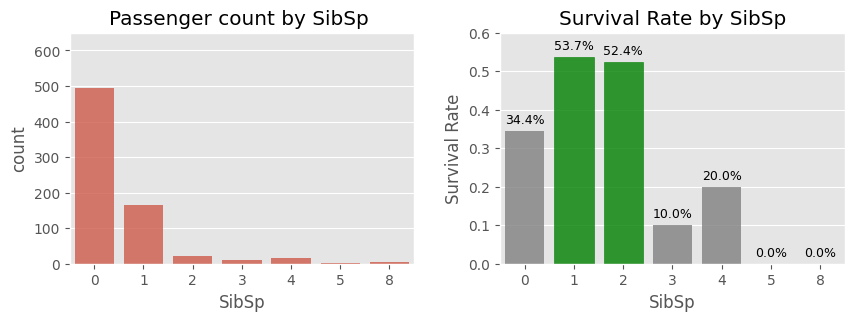

In [18]:
fig= plt.figure(figsize=(10,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="SibSp", data=train, alpha= 0.8, ax=ax1)
ax1.set_title("Passenger count by SibSp ")
ax1.set_ylim([0, 650])

ax2= plt.subplot(1,2,2)
sibsp_survival_rate = train.groupby('SibSp')['Survived'].mean().reset_index()
sns.barplot(x='SibSp', y='Survived', data=sibsp_survival_rate, alpha= 0.8, color='grey', ax= ax2)
for i in range(1,3):
    plt.gca().get_children()[i].set_color('g')
ax2.set_title('Survival Rate by SibSp')
ax2.set_xlabel('SibSp')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.6])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.25)
plt.show()

Here are the detailed counts for each category in the SibSp column:

In [19]:
SibSp_pivot= train.pivot_table(index= 'SibSp', columns='Survived', values='PassengerId', aggfunc='count', fill_value= 0)
SibSp_pivot.columns= ['No','Yes']
SibSp_pivot['Total'] = SibSp_pivot.sum(axis=1)
SibSp_pivot['Survival %']= round(SibSp_pivot['Yes']/SibSp_pivot['Total']*100,1).astype(str) + '%'
SibSp_pivot

,No,Yes,Total,Survival %
SibSp,,,,
0,324,170,494,34.4%
1,76,88,164,53.7%
2,10,11,21,52.4%
3,9,1,10,10.0%
4,12,3,15,20.0%
5,3,0,3,0.0%
8,5,0,5,0.0%


<h1 id="Parch"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;3.8. Parch
    <a class="anchor-link"
       href="#Parch"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Refers to the number of parents and/or children aboard. It is an int64 data type. We see below that the majority of passengers did not have parents or children aboard, and people with 2,3 and 4 Parch has the highest survival rate.

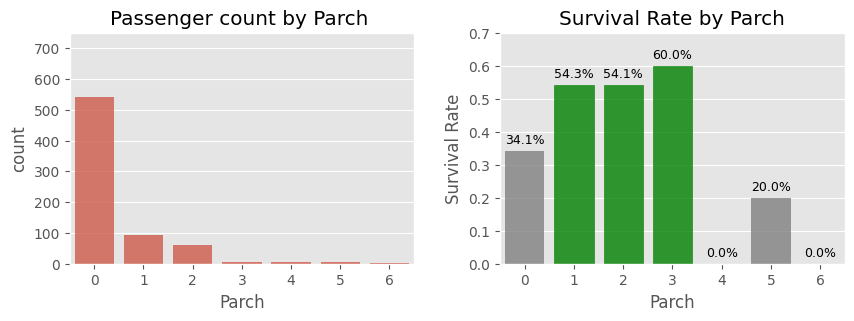

In [20]:
fig= plt.figure(figsize=(10,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Parch", data=train, alpha= 0.8, ax=ax1)
ax1.set_title("Passenger count by Parch ")
ax1.set_ylim([0, 750])

ax2= plt.subplot(1,2,2)
Parch_survival_rate = train.groupby('Parch')['Survived'].mean().reset_index().sort_values(by='Survived', ascending=False)
sns.barplot(x='Parch', y='Survived', data=Parch_survival_rate, alpha= 0.8, color='grey', ax= ax2)
for i in range(1,4):
    plt.gca().get_children()[i].set_color('g')
ax2.set_title('Survival Rate by Parch')
ax2.set_xlabel('Parch')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.7])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.25)
plt.show()

Here are the detailed counts for each category in the Parch column:

In [21]:
parch_pivot= train.pivot_table(index= 'Parch', columns='Survived', values='PassengerId', aggfunc='count', fill_value= 0)
parch_pivot.columns= ['No','Yes']
parch_pivot['Total'] = parch_pivot.sum(axis=1)
parch_pivot['Survival %']= round(parch_pivot['Yes']/parch_pivot['Total']*100,1).astype(str) +'%'
parch_pivot

,No,Yes,Total,Survival %
Parch,,,,
0,357,185,542,34.1%
1,43,51,94,54.3%
2,28,33,61,54.1%
3,2,3,5,60.0%
4,4,0,4,0.0%
5,4,1,5,20.0%
6,1,0,1,0.0%


<h1 id="Ticket"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;3.9. Ticket
    <a class="anchor-link"
       href="#Ticket"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Ticket number, datatype object. We notice below that a ticket number might belong to more than one passenger and some of the tickets has a string prefix.

In [22]:
train['Ticket'].value_counts()

Ticket
1601            6
347082          6
3101295         5
347088          5
S.O.C. 14879    5
               ..
312993          1
2695            1
2661            1
A4. 54510       1
113501          1
Name: count, Length: 571, dtype: int64

<h1 id="Fare"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;3.10. Fare
    <a class="anchor-link"
       href="#Fare"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Passenger Fare (British pound), datatype float64. As we saw before with the age variable, the ditribution of fare between train and test datasets is comparable. However,the boxplot shows that the majority of passengers who didn't survive paid less than the median fare paid by passengers who suvived . we also see that the fare varies, as there are 248 unique fare amounts paid. <br>
Note: in the boxplot, I eleminated the one passenger who paid more than 500 as this outlier was causing the whole plot to be more compressed, you can undo that by deleting the condition "[train['Fare']<500]"

In [23]:
print(F"Number of unique Fare values= {len(pd.unique(train['Fare']))}")

Number of unique Fare values= 226


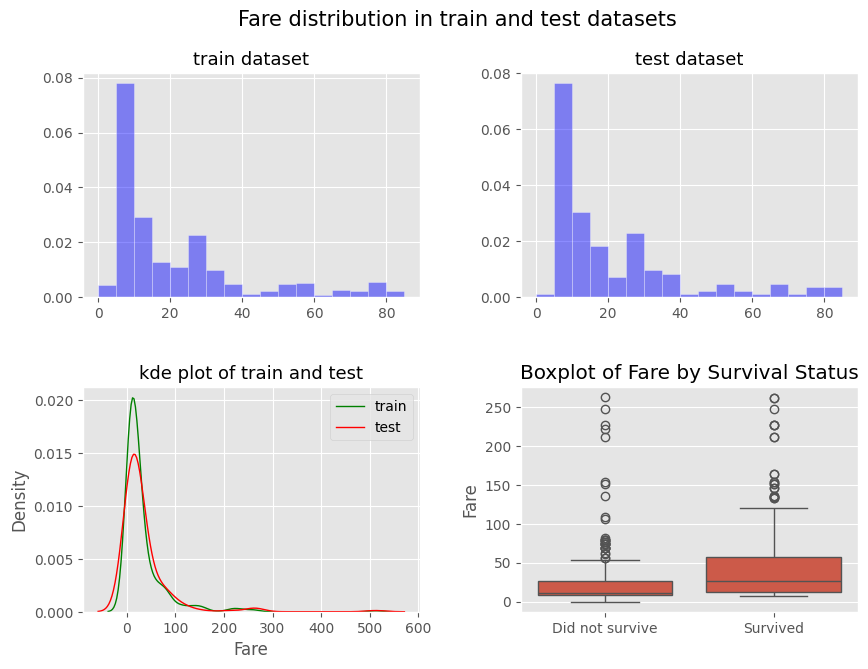

In [24]:
fig = plt.figure(figsize=(10, 7))

ax1 = plt.subplot(2, 2, 1)
count, bin_edges = np.histogram(train['Fare'], bins=range(0, 90, 5))
ax1.hist(train['Fare'].dropna(), bins=bin_edges, alpha= 0.45, density=True, color='blue', edgecolor='white')
ax1.set_title('train dataset', fontsize=13)

ax2 = plt.subplot(2, 2, 2)
count, bin_edges = np.histogram(test['Fare'], bins=range(0, 90, 5))
ax2.hist(test['Fare'].dropna(), bins=bin_edges, alpha= 0.45, density=True, color='blue', edgecolor='white')
ax2.set_title('test dataset', fontsize=13)

ax3 = plt.subplot(2, 2, 3)
sns.kdeplot(data=train, x='Fare', color='green', label='train', linewidth= 1, ax=ax3)
sns.kdeplot(data=test, x='Fare', color='red', label='test', linewidth= 1, ax=ax3)
ax3.legend()
ax3.set_title('kde plot of train and test', fontsize=13)

ax4 = plt.subplot(2, 2, 4)
sns.boxplot(data=train[train['Fare']<500], y="Fare", x="Survived", ax=ax4)
ax4.set_xticks([0, 1], ['Did not survive', 'Survived'])
ax4.set_title("Boxplot of Fare by Survival Status")
ax4.set_xlabel("")

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.suptitle('Fare distribution in train and test datasets', y=0.97, fontsize=15)
plt.show()

<h1 id="Cabin"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;3.11. Cabin
    <a class="anchor-link"
       href="#Cabin"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

The Cabin column contains a combination of letters and numbers that correspond to a passenger's assigned cabin. We can observe from the data that some passengers were assigned multiple cabins, and when this occurs, all the cabins share the same letter. Based on this observation, we can group passengers by the letter in their cabin code.

In [25]:
train['Cabin'].value_counts()

Cabin
G6      4
F2      3
E101    3
F33     3
E25     2
       ..
D6      1
C47     1
D45     1
A10     1
C7      1
Name: count, Length: 127, dtype: int64

<h1 id="Embarked"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;3.12. Embarked
    <a class="anchor-link"
       href="#Embarked"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

The "Embarked" column represents the port of embarkation and has a datatype of object. The values are "C" for Cherbourg, "Q" for Queenstown, and "S" for Southampton. We can see below that the majority of passengers who did not survive embarked in Southampton.

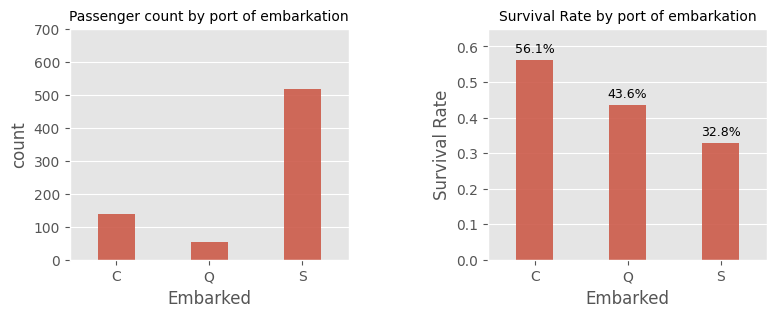

In [26]:
fig= plt.figure(figsize=(9,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Embarked", data=train, width= 0.4, alpha= 0.9, order=['C', 'Q', 'S'], ax=ax1)
ax1.set_title("Passenger count by port of embarkation", fontsize=10)
ax1.set_ylim([0, 700])


ax2= plt.subplot(1,2,2)
Embarked_survival_rate = train.groupby('Embarked')['Survived'].mean().reset_index()
sns.barplot(x='Embarked', y='Survived', data=Embarked_survival_rate,  alpha= 0.9, width= 0.4, ax= ax2)
ax2.set_title('Survival Rate by port of embarkation', fontsize=10)
ax2.set_xlabel('Embarked')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.65])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.5)
plt.show()

Here are the detailed counts for each category in the Embarked column:

In [27]:
embarked_pivot = train.pivot_table(index='Embarked', columns='Survived', values='PassengerId', aggfunc='count', fill_value= 0)
embarked_pivot.columns = ['No', 'Yes']
embarked_pivot['Total'] = embarked_pivot.sum(axis=1)
embarked_pivot['Survival %'] = round(embarked_pivot['Yes'] / embarked_pivot['Total']  * 100,1).astype(str) + '%'
embarked_pivot

,No,Yes,Total,Survival %
Embarked,,,,
C,61,78,139,56.1%
Q,31,24,55,43.6%
S,347,169,516,32.8%


<h1 id="Correlation"
     style="color: white;
            font-size: 28px;
            font-weight: bold;
            border-radius: 5px;
            background-color: #188193;
            border-bottom: 4px solid black;
            padding: 17px 0px 17px 30px;
            margin-top:20px">
    4. Correlation
    <a class="anchor-link"
       href="#Correlation"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Before making any changes to our data, let us examine the correlation matrix, we notice that:
- Survived is noticabily correlated with Pclass and Fare
- Pclass is noticabily correlated with Age and Fare.
- Age is noticabily correlated with Pclass, SibSp and Parch.
- SibSP is noticabily correlated with Parch and Fare.
- Parch is noticabily correlated with Fare.# 4. Correlation:# 4. Correlation:
Before making any changes to our data, let us examine the correlation matrix, we notice that:
- Survived is noticabily correlated with Pclass and Fare
- Pclass is noticabily correlated with Age and Fare.
- Age is noticabily correlated with Pclass, SibSp and Parch.
- SibSP is noticabily correlated with Parch and Fare.
- Parch is noticabily correlated with Fare.

In [28]:
# corr= train.corr()
# plt.figure(figsize= (10,10))
# sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.show()

<h1 id="Data_Wrangling"
     style="color: white;
            font-size: 28px;
            font-weight: bold;
            border-radius: 5px;
            background-color: #188193;
            border-bottom: 4px solid black;
            padding: 17px 0px 17px 30px;
            margin-top:20px">
    5. Data Wrangling
    <a class="anchor-link"
       href="#Data_Wrangling"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

<h1 id="Imputing_Missing_Values"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;5.1. Imputing Missing Values
    <a class="anchor-link"
       href="#Imputing_Missing_Values"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Below we can see three columns with missing values: Age, Cabin, and Embarked.

In [29]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            137
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          552
Embarked         2
dtype: int64

<h1 id="Missing_Values_in_Age_Column"
    style="color: #188193;
           font-size: 19px;
           font-weight: bold;
           margin-left: -46px">
    &#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;5.1.1 Missing Values in the Age Column
    <a class="anchor-link"
       href="#Missing_Values_in_Age_Column"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

A common approach to filling missing values in a numerical column is to replace them with the mean or median of that column. However, upon further analysis, we observe that the median age differs based on gender and passenger class. Specifically, the median age for men is higher than women in each of the three classes, and the median age for first class is higher than second class, which is also higher than third class. Thus, we can leverage this observation and replace the missing values in the age column using the median of the respective passenger class and gender grouping.

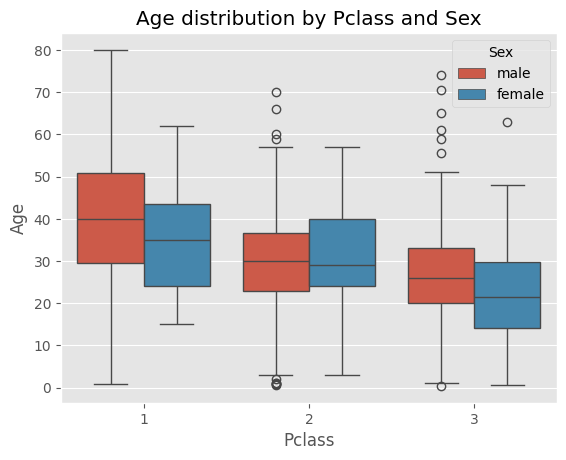

In [30]:
sns.boxplot(x='Pclass', y='Age', hue='Sex', data=train)
plt.title('Age distribution by Pclass and Sex')
plt.show()

Let's start by grouping Age by Pclass and Sex and using median as the aggregation funtion.

In [31]:
age_median = train.groupby(['Pclass','Sex'])['Age'].median()
age_median

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    29.0
        male      30.0
3       female    21.5
        male      26.0
Name: Age, dtype: float64

Impute missing values using the calculated medians

In [32]:
train['Age'] = train.apply(lambda x: age_median.loc[(x['Pclass'], x['Sex'])] if np.isnan(x['Age']) else x['Age'], axis=1)

<h1 id="Missing_Values_in_Embarked_Column"
    style="color: #188193;
           font-size: 19px;
           font-weight: bold;
           margin-left: -46px">
    &#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;5.1.2 Missing Values in the Embarked Column
    <a class="anchor-link"
       href="#Missing_Values_in_Embarked_Column"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

As for the "Embarked" column, we have only two missing values. We can either drop those rows or replace the missing values with the most frequent value in the column. In this case, I will choose the latter option and fill the missing values with the most frequent value of the "Embarked" column.<br>
Note: You can see below that I viewed the two records and looked all_data to see if someone with the same ticket number has the port of embarkation registered, which was a dead end.

In [33]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
562,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN
595,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN


In [34]:
all_data[all_data['Ticket']=='113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
562,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN
595,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN


In [35]:
most_frequent_value= train['Embarked'].value_counts().idxmax()
train['Embarked'].replace(np.nan, most_frequent_value, inplace=True)
print(F"Most frequent value= {most_frequent_value}")

Most frequent value= S


/tmp/ipykernel_64681/2622296200.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Embarked'].replace(np.nan, most_frequent_value, inplace=True)


<h1 id="Missing_Values_in_Cabin_Column"
    style="color: #188193;
           font-size: 19px;
           font-weight: bold;
           margin-left: -46px">
    &#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;5.1.3 Missing Values in the Cabin Column
    <a class="anchor-link"
       href="#Missing_Values_in_Cabin_Column"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Each cabin is identified by a letter and a number, some passengers are assigned more than one cabin but with the same letter. Therefore, we can drop the number keeping only the cabin letter. We will carry on imputing missing values in cabin in the feature engineering section below.

In [36]:
list(train["Cabin"].unique())

[nan,
 'C95',
 'A26',
 'C78',
 'D15',
 'E49',
 'C52',
 'C104',
 'A5',
 'F G73',
 'E44',
 'B96 B98',
 'D30',
 'C45',
 'G6',
 'C70',
 'B57 B59 B63 B66',
 'B80',
 'F E69',
 'C106',
 'E8',
 'D9',
 'E68',
 'D17',
 'B58 B60',
 'C125',
 'B18',
 'C83',
 'B3',
 'F33',
 'C92',
 'E121',
 'B22',
 'E33',
 'C23 C25 C27',
 'E67',
 'B35',
 'C85',
 'F2',
 'E12',
 'A14',
 'B86',
 'A10',
 'D45',
 'C47',
 'D33',
 'D6',
 'C91',
 'C62 C64',
 'C65',
 'B101',
 'A7',
 'A31',
 'D49',
 'D11',
 'D35',
 'E101',
 'B69',
 'B102',
 'C7',
 'C2',
 'C124',
 'C82',
 'B4',
 'A34',
 'D26',
 'C110',
 'A19',
 'B42',
 'A16',
 'B78',
 'B94',
 'B50',
 'E34',
 'C99',
 'C118',
 'D10 D12',
 'E46',
 'B39',
 'B19',
 'C68',
 'B37',
 'A20',
 'B30',
 'A24',
 'D56',
 'E58',
 'E25',
 'E36',
 'F4',
 'T',
 'D',
 'C126',
 'C32',
 'C22 C26',
 'E17',
 'C90',
 'D19',
 'E24',
 'D47',
 'E38',
 'B82 B84',
 'B49',
 'E50',
 'B28',
 'C93',
 'F G63',
 'D21',
 'E77',
 'C46',
 'E10',
 'D20',
 'A32',
 'C123',
 'A23',
 'E40',
 'B20',
 'A36',
 'D36',
 'B7

<h1 id="Feature_Engineering"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;5.2. Feature Engineering
    <a class="anchor-link"
       href="#Feature_Engineering"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

<h1 id="Cabin_Letter"
    style="color: #188193;
           font-size: 19px;
           font-weight: bold;
           margin-left: -46px">
    &#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;5.2.1. Cabin_Letter
    <a class="anchor-link"
       href="#Cabin_Letter"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

We will start by creating a new feature named `Cabin_Letter` by extracting the first letter in cabin and replacing empty values with Unknown then we drop the Cabin column:

In [37]:
train['Cabin_Letter'] = train['Cabin'].str[:1]
train.Cabin_Letter.fillna('Unknown', inplace=True)
train= train.drop(columns=['Cabin'])

/tmp/ipykernel_64681/206096840.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train.Cabin_Letter.fillna('Unknown', inplace=True)


In [38]:
train.Cabin_Letter.value_counts()

Cabin_Letter
Unknown    552
C           41
B           34
E           29
D           26
A           14
F           11
G            4
T            1
Name: count, dtype: int64

In the plot below we can see that cabin letters which indicate the passengers' location on the Titanic affected their survival as passengers with some Cabin letters had higher survival rate than others. Thay will make this feature useful and help our model gain some information.

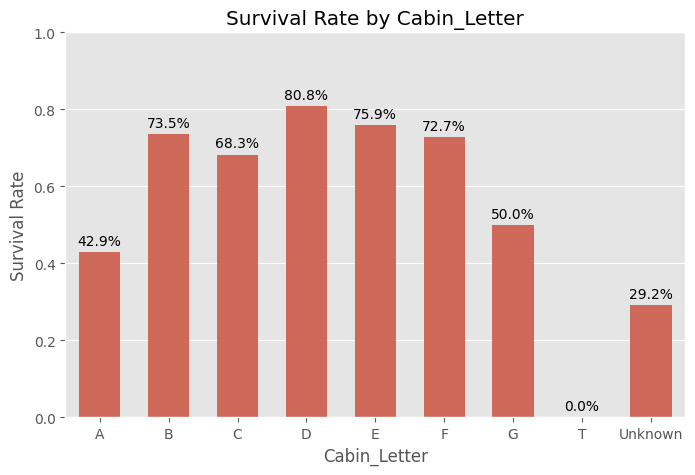

In [39]:
fig= plt.figure(figsize=(8,5))

Cabin_Letter_survival_rate = train.groupby('Cabin_Letter')['Survived'].mean().reset_index()
ax= sns.barplot(x='Cabin_Letter', y='Survived', data=Cabin_Letter_survival_rate,  alpha= 0.9, width= 0.6)
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 8),
                textcoords='offset points')
plt.title('Survival Rate by Cabin_Letter', )
plt.xlabel('Cabin_Letter')
plt.ylabel('Survival Rate')
plt.ylim([0, 1])

plt.show()

<h1 id="Is_Female"
    style="color: #188193;
           font-size: 19px;
           font-weight: bold;
           margin-left: -46px">
    &#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;5.2.2. Is_Female
    <a class="anchor-link"
       href="#Is_Female"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Now let's create a binary column `Is_Female` to represent female passengers in the data. This avoids redundant one-hot encoding for male and female, and can be used as a binary feature in analysis and our machine learning models. The original 'Sex' column is retained for potential future use.

In [40]:
train['Is_Female']= train.Sex.apply(lambda x: 1 if x=='female' else 0)

<h1 id="Family_Size"
    style="color: #188193;
           font-size: 19px;
           font-weight: bold;
           margin-left: -46px">
    &#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;5.2.3. Family_Size
    <a class="anchor-link"
       href="#Family_Size"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

`Family_Size` is created by adding `Parch` and `SibSp` plus `1`:

In [41]:
train['Family_Size']= train['Parch'] + train['SibSp'] + 1

Plotting the `Family_Size` feature reveals that the majority of passengers are traveling without family members. Additionally, families consisting of 2, 3, and 4 members exhibit the highest survival rates, while families with more than 7 members have a 0% survival rate. This information suggests that family size could be a relevant factor in predicting survival chances>

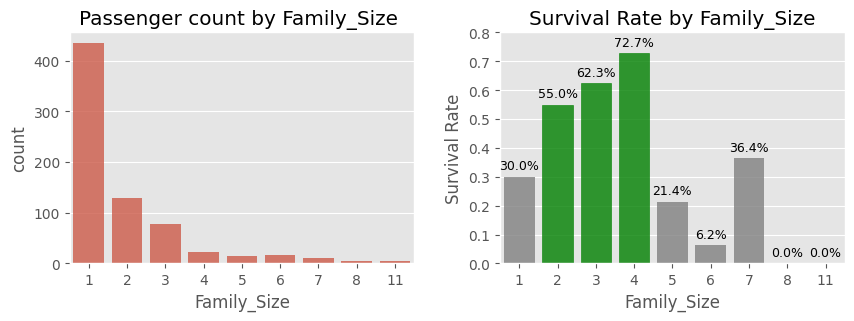

In [42]:
fig= plt.figure(figsize=(10,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Family_Size", data=train, alpha= 0.8, ax=ax1)
ax1.set_title("Passenger count by Family_Size ")

ax2= plt.subplot(1,2,2)
Family_Size_survival_rate = train.groupby('Family_Size')['Survived'].mean().reset_index().sort_values(by='Survived', ascending=False)
sns.barplot(x='Family_Size', y='Survived', data=Family_Size_survival_rate, alpha= 0.8, color='grey', ax= ax2)
for i in range(1,4):
    plt.gca().get_children()[i].set_color('g')
ax2.set_title('Survival Rate by Family_Size')
ax2.set_xlabel('Family_Size')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.8])

for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.25)
plt.show()

Let's now group the family size values into four categories, namely 'Alone' for family size 1, 'Small' for family size 2, 3, or 4, 'Medium' for family size 5 or 6, and 'Large' for family size 7, 8, or 11. This grouping helps in categorizing passengers based on their family size:

In [43]:
train['Family_Size']=train['Family_Size'].map({1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'})

<h1 id="Group_Size"
    style="color: #188193;
           font-size: 19px;
           font-weight: bold;
           margin-left: -46px">
    &#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;5.2.4. Group_Size
    <a class="anchor-link"
       href="#Group_Size"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

`Group_Size` is the number of passengers with the same ticket, we fill this column up with the frequency of the passenger's ticket after calculating ticket frequency in all data:

In [44]:
tickets= all_data.groupby(['Ticket'])[['PassengerId']].count().rename(columns={'PassengerId': 'Count'})
tickets.head()

,Count
Ticket,
110152,3
110413,3
110465,2
110564,1
110813,1


In [45]:
train['Group_Size']=train['Ticket'].apply(lambda x: tickets.loc[x, 'Count'])

<h1 id="Title"
    style="color: #188193;
           font-size: 19px;
           font-weight: bold;
           margin-left: -46px">
    &#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;5.2.5. Title
    <a class="anchor-link"
       href="#Title"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

We will extract the titles from the name field and make a new feature `Title`, which would help us capture information about the social status of passengers

In [46]:
train['Title'] = train['Name'].str.split(', ').str[1].str.split('.').str[0]

Extracting all titles from train and test:

In [47]:
all_data['Title'] = all_data['Name'].str.split(', ').str[1].str.split('.').str[0]
all_data['Title'].unique()

array(['Mr', 'Mrs', 'Col', 'Miss', 'Rev', 'Major', 'Master', 'Dr', 'Mlle',
       'Lady', 'Sir', 'Ms', 'Jonkheer', 'Don', 'Mme', 'Capt',
       'the Countess'], dtype=object)

let's group some of the titles together:

In [48]:

title_mapping= {'Mr':'Mr', 'Mrs':'Mrs', 'Miss':'Miss','Master':'Master', 'Don':'Rare', 'Rev':'Rare', 'Dr':'Rare', 'Mme':'Mrs', 'Ms':'Miss',
       'Major':'Rare', 'Lady':'Rare' , 'Sir':'Rare', 'Mlle':'Miss', 'Col':'Rare', 'Capt':'Rare', 'the Countess':'Rare',
       'Jonkheer':'Rare', 'Dona':'Rare'}
train['Title']= train['Title'].map(title_mapping)

In [49]:
train['Title'].value_counts()

Title
Mr        412
Miss      144
Mrs       107
Master     31
Rare       18
Name: count, dtype: int64

<h1 id="Fare_bin"
    style="color: #188193;
           font-size: 19px;
           font-weight: bold;
           margin-left: -46px">
    &#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;5.2.6. Fare_bin
    <a class="anchor-link"
       href="#Fare_bin"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Let's look again at the destribution of data in Fare column using a box plot. <br>
Note that I showed two boxplots of the Fare column, the only difference is that I eliminated one outlier (>500) in the plot on the right to show a less compressed plot.

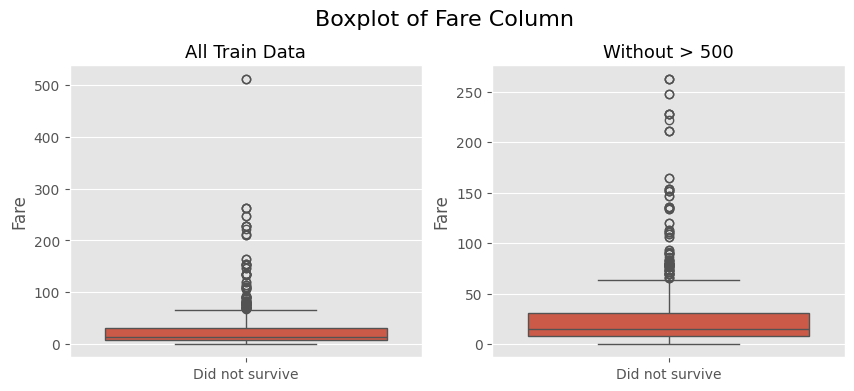

In [50]:
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1, 2, 1)
sns.boxplot(data=train, y="Fare", ax=ax1)
ax1.set_xticks([0], ['Did not survive'])
ax1.set_title("All Train Data", fontsize= 13)

ax2 = plt.subplot(1, 2, 2)
sns.boxplot(data=train[train['Fare']<500], y="Fare",  ax=ax2)
ax2.set_xticks([0], ['Did not survive'])
ax2.set_title("Without > 500", fontsize= 13)

plt.suptitle('Boxplot of Fare Column', fontsize= 16)
plt.subplots_adjust(top=0.84)

plt.show()

We will bin the 'Fare' column by calculating the quartiles and defining bin edges based on them. This will create 5 bins:

In [51]:
Q1, Q2, Q3 = np.percentile(train['Fare'], [25, 50, 75])
IQR = Q3 - Q1

fare_bin_edges = [-np.inf, Q1, Q2, Q3, 1.5 * IQR, np.inf]

fare_bin_labels=[]
for i in range(len(fare_bin_edges)-1):
    fare_bin_labels.append("{}_to_{}".format(fare_bin_edges[i], fare_bin_edges[i+1]))

train['Fare_bin'] = pd.cut(train['Fare'], bins=fare_bin_edges, labels=fare_bin_labels)

Notice that I didn't use the lower edge which is calculated as below, because it's below zero:

In [52]:
print(Q1 - 1.5 * IQR)

-26.7605


Number of passenger in each Fare_bin:

In [53]:
train[['Fare_bin']].value_counts()

Fare_bin         
7.8958_to_14.4542    181
-inf_to_7.8958       180
14.4542_to_31.0      175
34.6563_to_inf       157
31.0_to_34.6563       19
Name: count, dtype: int64

Passenger in the highest fare bin have the highest survival rate while those in the lowest fare bin have the lowest survival rate:

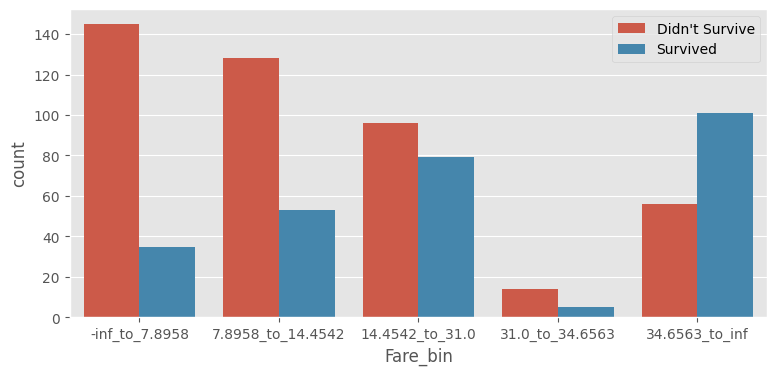

In [54]:
plt.figure(figsize=(9,4))
sns.countplot(x='Fare_bin', hue='Survived', data=train)
plt.legend(labels=["Didn't Survive","Survived"])
plt.show()

<h1 id="Age_bin"
    style="color: #188193;
           font-size: 19px;
           font-weight: bold;
           margin-left: -46px">
    &#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;5.2.7. Age_bin
    <a class="anchor-link"
       href="#Age_bin"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Let's also make bins for Age, I will divivde Age into 10 bins, from 0 to 80 years old

In [55]:
Q1 = train['Age'].quantile(0.25)
Q3 = train['Age'].quantile(0.75)
IQR = Q3 - Q1

num_bins = 10
age_bin_edges = np.linspace(start=0, stop=train.Age.max(), num=num_bins + 1).astype(int)

age_bin_labels=[]
for i in range(len(age_bin_edges)-1):
    age_bin_labels.append("{}_to_{}".format(age_bin_edges[i], age_bin_edges[i+1]))

train['Age_bin'] = pd.cut(train['Age'], bins=age_bin_edges, labels= age_bin_labels)

Below we can see from the value count that we probably can benefit from looking into further dividing the three bins with the highest number of passengers. I will keep them as they are for now:

In [56]:
train['Age_bin'].value_counts()

Age_bin
24_to_32    210
16_to_24    179
32_to_40    126
40_to_48     57
0_to_8       46
48_to_56     39
8_to_16      30
56_to_64     15
64_to_72      8
72_to_80      2
Name: count, dtype: int64

When we plot the age bins, we notice that the only bin with more surviving passengers than perishing ones is the bin that includes passengers aged 0 to 8 years.

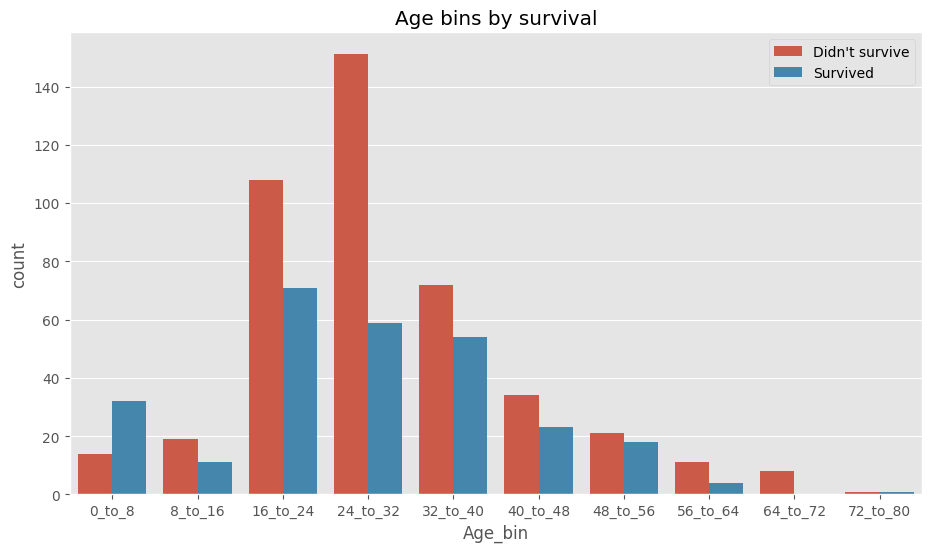

In [57]:
plt.figure(figsize=(11,6))
sns.countplot(x='Age_bin', hue='Survived', data=train)
plt.legend(["Didn't survive","Survived"])
plt.title('Age bins by survival')
plt.show()

<h1 id="Feature_Interaction"
    style="color: #188193;
           font-size: 19px;
           font-weight: bold;
           margin-left: -46px">
    &#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;&#160;5.2.8. Feature Interaction
    <a class="anchor-link"
       href="#Feature_Interaction"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Now we will creat multiple features using the interactions between the features we have:

In [58]:
train["Age_bin_Sex"] = train["Age_bin"].astype(str) + "_" + train["Sex"]
train["Age_bin_Pclass"] = train["Age_bin"].astype(str) + "_" + train["Pclass"].astype(str)

train["Fare_bin_Sex"] = train["Fare_bin"].astype(str) + "_" + train["Sex"]
train["Fare_bin_Pclass"] = train["Fare_bin"].astype(str) + "_" + train["Pclass"].astype(str)

train["Pclass_Sex"] = train["Pclass"].astype(str) + "_" + train["Sex"]
train["Pclass_Title"] = train["Pclass"].astype(str) + "_" + train["Title"]
train["Sex_Title"] = train["Sex"].astype(str) + "_" + train["Title"]

train["Age_bin_Title"] = train["Age_bin"].astype(str) + "_" + train["Title"]
train["Fare_bin_Title"] = train["Fare_bin"].astype(str) + "_" + train["Title"]

train['Fam_Size_Cabin']= train["Family_Size"].astype(str) + "_" + train["Cabin_Letter"].astype(str)
train['Fam_Size_Parch']= train["Family_Size"].astype(str) + "_" + train["Parch"].astype(str)
train['Fam_Size_Fare_bin']= train["Family_Size"].astype(str) + "_" + train["Fare_bin"].astype(str)

train['SibSp_Parch_Ratio'] = train.apply(lambda x: x['SibSp'] / train.loc[x.name, 'Parch'] if train.loc[x.name, 'Parch'] != 0 else 0, axis=1)
train['Age_bin_Fare_bin']= train["Age_bin"].astype(str) + "_" + train["Fare_bin"].astype(str)

<h1 id="Applying_the_Same_Changes_on_the_Test_Dataset"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;5.3. Applying the Same Changes on the Test Dataset
    <a class="anchor-link"
       href="#Applying_the_Same_Changes_on_the_Test_Dataset"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Missing values:

In [59]:
test.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             40
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          135
Embarked         0
dtype: int64

Filling missing values in Age column:

In [60]:
test['Age'] = test.apply(lambda x: age_median.loc[(x['Pclass'], x['Sex'])] if np.isnan(x['Age']) else x['Age'], axis=1)

Let's take a look at the row with the missing value in the Fare column:

In [61]:
test[test.isnull()['Fare']== True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Since the passenger above isn't traveling with any family number, we can't find the exact fare for him, so let's replace the fare value with the mean of the Fare column.

In [62]:
avg_fare = test["Fare"].mean(axis=0)
test["Fare"].replace(np.nan, avg_fare, inplace=True)

/tmp/ipykernel_64681/536741997.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test["Fare"].replace(np.nan, avg_fare, inplace=True)


We need to structure the new features we created in the feature engineering process, ideally, we would do that using a function or a pipeline, but since this process is for learning, I will do it step by step:

In [63]:
#Cabin_Letter
test['Cabin_Letter'] = test['Cabin'].str[:1]
test.Cabin_Letter= test.Cabin_Letter.fillna('Unknown')

#Family_Size
test['Family_Size']= test['Parch'] + test['SibSp'] + 1
test['Family_Size']=test['Family_Size'].map({1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'})

#Is_Female
test['Is_Female']= test.Sex.apply(lambda x: 1 if x=='female' else 0)

#Group_Size
test['Group_Size']=test['Ticket'].apply(lambda x: tickets.loc[x, 'Count'])

#Title
test['Title'] = test['Name'].str.split(', ').str[1].str.split('.').str[0]
test['Title']= test['Title'].map(title_mapping)

#Fare_bin
test['Fare_bin'] = pd.cut(test['Fare'], bins=fare_bin_edges, labels=fare_bin_labels)

#Age_bins
test['Age_bin'] = pd.cut(test['Age'], bins=age_bin_edges, labels=age_bin_labels)

#SibSp_Parch Ratio
test['SibSp_Parch_Ratio'] = test.apply(lambda x: x['SibSp'] / test.loc[x.name, 'Parch'] if test.loc[x.name, 'Parch'] != 0 else 0, axis=1)

#Age_bin / Sex
test["Age_bin_Sex"] = test["Age_bin"].astype(str) + "_" + test["Sex"]

#Age_bin / Pcalss
test["Age_bin_Pclass"] = test["Age_bin"].astype(str) + "_" + test["Pclass"].astype(str)

#Fare_bin / Sex
test["Fare_bin_Sex"] = test["Fare_bin"].astype(str) + "_" + train["Sex"]

#Fare_bin / Pclass
test["Fare_bin_Pclass"] = test["Fare_bin"].astype(str) + "_" + test["Pclass"].astype(str)

#Pclass / Sex
test["Pclass_Sex"] = test["Pclass"].astype(str) + "_" + test["Sex"]

#Pclass / Title
test["Pclass_Title"] = test["Pclass"].astype(str) + "_" + test["Title"]

#Sex / Title
test["Sex_Title"] = test["Sex"].astype(str) + "_" + test["Title"]

#Age_bin / Title
test["Age_bin_Title"] = test["Age_bin"].astype(str) + "_" + test["Title"]

#Fare_bin / Title
test["Fare_bin_Title"] = test["Fare_bin"].astype(str) + "_" + test["Title"]

#Fam_Size / Cabin_Letter
test['Fam_Size_Cabin']= test["Family_Size"].astype(str) + "_" + test["Cabin_Letter"].astype(str)

#Fam_Size / Parch
test['Fam_Size_Parch']= test["Family_Size"].astype(str) + "_" + test["Parch"].astype(str)

#Fam_Size / Fare_bin
test['Fam_Size_Fare_bin']= test["Family_Size"].astype(str) + "_" + test["Fare_bin"].astype(str)


test.drop(columns=['Cabin'],inplace= True)

test['Age_bin_Fare_bin']= test["Age_bin"].astype(str) + "_" + test["Fare_bin"].astype(str)

<h1 id="Dropping_Unnecessary_Columns"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;5.4. Dropping Unnecessary Columns
    <a class="anchor-link"
       href="#Dropping_Unnecessary_Columns"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

In [64]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Cabin_Letter', 'Is_Female',
       'Family_Size', 'Group_Size', 'Title', 'Fare_bin', 'Age_bin',
       'Age_bin_Sex', 'Age_bin_Pclass', 'Fare_bin_Sex', 'Fare_bin_Pclass',
       'Pclass_Sex', 'Pclass_Title', 'Sex_Title', 'Age_bin_Title',
       'Fare_bin_Title', 'Fam_Size_Cabin', 'Fam_Size_Parch',
       'Fam_Size_Fare_bin', 'SibSp_Parch_Ratio', 'Age_bin_Fare_bin'],
      dtype='object')

In [65]:
cols_to_drop=['Sex','Name','Ticket']
for df in [train,test]:
    df.drop(columns=cols_to_drop, inplace= True)

In [66]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Cabin_Letter,Is_Female,Family_Size,Group_Size,Title,Fare_bin,Age_bin,Age_bin_Sex,Age_bin_Pclass,Fare_bin_Sex,Fare_bin_Pclass,Pclass_Sex,Pclass_Title,Sex_Title,Age_bin_Title,Fare_bin_Title,Fam_Size_Cabin,Fam_Size_Parch,Fam_Size_Fare_bin,SibSp_Parch_Ratio,Age_bin_Fare_bin
0,693,1,3,26.0,0,0,56.4958,S,Unknown,0,Alone,7,Mr,34.6563_to_inf,24_to_32,24_to_32_male,24_to_32_3,34.6563_to_inf_male,34.6563_to_inf_3,3_male,3_Mr,male_Mr,24_to_32_Mr,34.6563_to_inf_Mr,Alone_Unknown,Alone_0,Alone_34.6563_to_inf,0.0,24_to_32_34.6563_to_inf
1,482,0,2,30.0,0,0,0.0000,S,Unknown,0,Alone,1,Mr,-inf_to_7.8958,24_to_32,24_to_32_male,24_to_32_2,-inf_to_7.8958_male,-inf_to_7.8958_2,2_male,2_Mr,male_Mr,24_to_32_Mr,-inf_to_7.8958_Mr,Alone_Unknown,Alone_0,Alone_-inf_to_7.8958,0.0,24_to_32_-inf_to_7.8958
2,528,0,1,40.0,0,0,221.7792,S,C,0,Alone,1,Mr,34.6563_to_inf,32_to_40,32_to_40_male,32_to_40_1,34.6563_to_inf_male,34.6563_to_inf_1,1_male,1_Mr,male_Mr,32_to_40_Mr,34.6563_to_inf_Mr,Alone_C,Alone_0,Alone_34.6563_to_inf,0.0,32_to_40_34.6563_to_inf
3,856,1,3,18.0,0,1,9.3500,S,Unknown,1,Small,1,Mrs,7.8958_to_14.4542,16_to_24,16_to_24_female,16_to_24_3,7.8958_to_14.4542_female,7.8958_to_14.4542_3,3_female,3_Mrs,female_Mrs,16_to_24_Mrs,7.8958_to_14.4542_Mrs,Small_Unknown,Small_1,Small_7.8958_to_14.4542,0.0,16_to_24_7.8958_to_14.4542
4,802,1,2,31.0,1,1,26.2500,S,Unknown,1,Small,3,Mrs,14.4542_to_31.0,24_to_32,24_to_32_female,24_to_32_2,14.4542_to_31.0_female,14.4542_to_31.0_2,2_female,2_Mrs,female_Mrs,24_to_32_Mrs,14.4542_to_31.0_Mrs,Small_Unknown,Small_1,Small_14.4542_to_31.0,1.0,24_to_32_14.4542_to_31.0


<h1 id="One_Hot_Encoding_Categorical_Columns"
    style="color: #188193;
           font-size: 23px;
           font-weight: bold;
           margin-left: -28px">
    &#160;&#160;&#160;&#160;&#160;5.5. One-Hot Encoding Categorical Columns
    <a class="anchor-link"
       href="#One_Hot_Encoding_Categorical_Columns"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

In [67]:

cat_variables= ['Embarked',
                'Fam_Size_Cabin',
                'Fam_Size_Parch',
                'Fam_Size_Fare_bin' ,
                'Cabin_Letter',
                'Title',
                'Family_Size',
                'Age_bin_Sex',
                'Age_bin_Pclass',
                'Fare_bin_Sex',
                'Fare_bin_Pclass',
                'Fare_bin_Title',
                'Pclass_Sex',
                'Pclass_Title',
                'Sex_Title',
                'Age_bin_Title',
                'Fare_bin',
                'Age_bin',
                'Age_bin_Fare_bin']

train = pd.get_dummies(data = train,
                       prefix = cat_variables,
                       columns = cat_variables)

test = pd.get_dummies(data = test,
                      prefix = cat_variables,
                      columns = cat_variables)

In [68]:
print(F"Number of columns in train= {train.shape[1]}")
print(F"Number of columns in test= {test.shape[1]}")

Number of columns in train= 294
Number of columns in test= 244


Let's now align train and test columns so that we have the same columns in both of them:

In [69]:
train, test = train.align(test, axis=1, fill_value=0)

In [70]:
print(F"Number of columns in train= {train.shape[1]}")
print(F"Number of columns in test= {train.shape[1]}")

Number of columns in train= 295
Number of columns in test= 295


<h1 id="Feature_Selection"
     style="color: white;
            font-size: 28px;
            font-weight: bold;
            border-radius: 5px;
            background-color: #188193;
            border-bottom: 4px solid black;
            padding: 17px 0px 17px 30px;
            margin-top:20px">
    6. Feature Selection
    <a class="anchor-link"
       href="#Feature_Selection"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Most of the features generated through feature engineering are binary, indicating that the column is filled with 0 if the passenger does not belong to the group represented by the feature, and 1 if the passenger does belong to the group. By summing the binary columns, we can determine the number of passengers included in each feature. If a feature has a very small number of passengers, it may not be helpful, and keeping it could lead to overfitting, as our model would have to consider a characteristic that only applies to one or a few passenger. Therefore, let's select the binary features that include at least 10% of the passengers, and from those that include less than 10% of passengers we will only take those with a correlation >= 0.15 with the target 'Survived' <br>
Note that we have to drop the target column 'Survived'.

In [71]:
corr_with_survived= train.corr()[['Survived']] 
selected_binary_features = [col for col in train.columns 
                            if set(train[col].unique()) == {0, 1} 
                                and (train[col].sum()/len(train) > 0.1 and  abs(corr_with_survived.loc[col].values[0])>= 0.15 )]



if 'Survived' in selected_binary_features:
    selected_binary_features.remove('Survived')
print(F"Number of selected binary features= {len(selected_binary_features)}")
selected_binary_features

Number of selected binary features= 40


['Age_bin_Fare_bin_24_to_32_-inf_to_7.8958',
 'Age_bin_Pclass_24_to_32_3',
 'Age_bin_Sex_16_to_24_female',
 'Age_bin_Sex_16_to_24_male',
 'Age_bin_Sex_24_to_32_male',
 'Age_bin_Sex_32_to_40_male',
 'Age_bin_Title_16_to_24_Mr',
 'Age_bin_Title_24_to_32_Mr',
 'Cabin_Letter_Unknown',
 'Embarked_C',
 'Embarked_S',
 'Fam_Size_Cabin_Alone_Unknown',
 'Fam_Size_Fare_bin_Alone_-inf_to_7.8958',
 'Fam_Size_Fare_bin_Small_34.6563_to_inf',
 'Fam_Size_Parch_Alone_0',
 'Fam_Size_Parch_Small_1',
 'Family_Size_Alone',
 'Family_Size_Small',
 'Fare_bin_-inf_to_7.8958',
 'Fare_bin_34.6563_to_inf',
 'Fare_bin_Pclass_-inf_to_7.8958_3',
 'Fare_bin_Pclass_34.6563_to_inf_1',
 'Fare_bin_Sex_-inf_to_7.8958_male',
 'Fare_bin_Sex_14.4542_to_31.0_female',
 'Fare_bin_Sex_34.6563_to_inf_female',
 'Fare_bin_Sex_7.8958_to_14.4542_male',
 'Fare_bin_Title_-inf_to_7.8958_Mr',
 'Fare_bin_Title_7.8958_to_14.4542_Mr',
 'Is_Female',
 'Pclass_Sex_1_female',
 'Pclass_Sex_2_male',
 'Pclass_Sex_3_male',
 'Pclass_Title_2_Mr',
 'Pc

Let's take a look at the non_binary_features, we have to drop `PassengerId` because it's an id column and not a feature:

In [72]:
non_binary_features= [col for col in train.columns if set(train[col].unique()) != {0, 1} and col != 'PassengerId']
print(F"Number of non binary features= {len(non_binary_features)}")
non_binary_features

Number of non binary features= 8


['Age',
 'Age_bin_Title_64_to_72_Rare',
 'Fare',
 'Group_Size',
 'Parch',
 'Pclass',
 'SibSp',
 'SibSp_Parch_Ratio']

Now let's combine the selected_binary_features and non_binary_features in one list named features:

In [73]:
features=  non_binary_features + selected_binary_features
print(len(features))
features

48


['Age',
 'Age_bin_Title_64_to_72_Rare',
 'Fare',
 'Group_Size',
 'Parch',
 'Pclass',
 'SibSp',
 'SibSp_Parch_Ratio',
 'Age_bin_Fare_bin_24_to_32_-inf_to_7.8958',
 'Age_bin_Pclass_24_to_32_3',
 'Age_bin_Sex_16_to_24_female',
 'Age_bin_Sex_16_to_24_male',
 'Age_bin_Sex_24_to_32_male',
 'Age_bin_Sex_32_to_40_male',
 'Age_bin_Title_16_to_24_Mr',
 'Age_bin_Title_24_to_32_Mr',
 'Cabin_Letter_Unknown',
 'Embarked_C',
 'Embarked_S',
 'Fam_Size_Cabin_Alone_Unknown',
 'Fam_Size_Fare_bin_Alone_-inf_to_7.8958',
 'Fam_Size_Fare_bin_Small_34.6563_to_inf',
 'Fam_Size_Parch_Alone_0',
 'Fam_Size_Parch_Small_1',
 'Family_Size_Alone',
 'Family_Size_Small',
 'Fare_bin_-inf_to_7.8958',
 'Fare_bin_34.6563_to_inf',
 'Fare_bin_Pclass_-inf_to_7.8958_3',
 'Fare_bin_Pclass_34.6563_to_inf_1',
 'Fare_bin_Sex_-inf_to_7.8958_male',
 'Fare_bin_Sex_14.4542_to_31.0_female',
 'Fare_bin_Sex_34.6563_to_inf_female',
 'Fare_bin_Sex_7.8958_to_14.4542_male',
 'Fare_bin_Title_-inf_to_7.8958_Mr',
 'Fare_bin_Title_7.8958_to_14.4

<h1 id="Tuning_XGBoost_Model"
     style="color: white;
            font-size: 28px;
            font-weight: bold;
            border-radius: 5px;
            background-color: #188193;
            border-bottom: 4px solid black;
            padding: 17px 0px 17px 30px;
            margin-top:20px">
    7. Tuning XGBoost Model
    <a class="anchor-link"
       href="#Tuning_XGBoost_Model"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

We will use the features above to tune the hypermeters for xgboost. We will use `gridsearchcv` with `stratifiedkfold` to do a grid search for the optimal hypermeters, here we go:
Note that I commented the cell below because it takes time to run, but I put the result of running it at the end of it so you can see it.

In [74]:
#Grid_Search:
'''
%%time
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train[features], train['Survived'], train_size = 0.7, random_state = seed)

# Define the hyperparameters to be tuned
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1, 3, 5, 7],
    'n_estimators': [50, 100, 150, 200 ],
    'colsample_bytree': [ 0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'min_child_weight': [1, 3, 5, 7 ],
    'early_stopping_rounds': [10, 15, 20]
}

# Create an XGBoost model
xgb_model = XGBClassifier()

# Use GridSearchCV to find the optimal hyperparameters
cv_strat = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv_strat, n_jobs=-1, verbose=1)
grid_search.fit(train[features], train['Survived'], eval_set=[(X_val, y_val)], verbose=False)

# Print the best hyperparameters
print(grid_search.best_params_)
'''

##################
#Result:

'''
Fitting 3 folds for each of 6912 candidates, totalling 20736 fits
{'colsample_bytree': 1.0, 'early_stopping_rounds': 10, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 200, 'reg_alpha': 0}
CPU times: user 2min 38s, sys: 5.02 s, total: 2min 43s
Wall time: 1h 29min 6s
'''

"\nFitting 3 folds for each of 6912 candidates, totalling 20736 fits\n{'colsample_bytree': 1.0, 'early_stopping_rounds': 10, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 200, 'reg_alpha': 0}\nCPU times: user 2min 38s, sys: 5.02 s, total: 2min 43s\nWall time: 1h 29min 6s\n"

Using the parameters above, let's initiate our model

In [75]:
xgb_model = XGBClassifier(colsample_bytree= 0.6,
                          early_stopping_rounds=10, 
                          learning_rate= 0.05,
                          max_depth= 5,
                          min_child_weight= 7,
                          n_estimators= 200,
                          reg_alpha= 0,
                          random_state= seed,
                          objective= 'binary:logistic')

<h1 id="Training_and_Evaluationg_the_XGBoost_Model"
     style="color: white;
            font-size: 28px;
            font-weight: bold;
            border-radius: 5px;
            background-color: #188193;
            border-bottom: 4px solid black;
            padding: 17px 0px 17px 30px;
            margin-top:20px">
    8. Training and Evaluating the XGBoost Model
    <a class="anchor-link"
       href="#Training_and_Evaluationg_the_XGBoost_Model"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

We will use `train_test_split` split our data into two sets, train and val, then we will `stratifiedkfold` for dividing our data into multiple folds and use these folds to train and validate multiple models, then we use the multiple trained model to make prediction on the held out val set for validation, then we will also use the three models to make prediction on the test set for submission.

let's start by splitting our data:

In [76]:
X_train, X_val, y_train, y_val = train_test_split(train[features], train['Survived'], train_size = 0.7, random_state = seed)

Initiating some variables:

In [77]:
#Number of folds
N = 3

#Creating a dataframe for storing the multiple folds' probability of one, in other words, probability of survival for predicting val set and test set
test_probs_of_one = pd.DataFrame(np.zeros((len(test), N)), columns= ['Fold_{}'.format(i) for i in range(1, N + 1)])

#Creating a dataframe for storing feature importances
feature_importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=features)

# create empty lists to store the predictions and scores for each fold
fold_train_scores = []
fold_val_scores = []

Now let's create the Stratifiedkfold object:

In [78]:
skf = StratifiedKFold(n_splits=N, shuffle=True, random_state=seed)

We are ready to start training our models, we will use a for loop to iterate through folds and get probabilities, feature importances and scores stored in the dataphrames and lists above: 

In [79]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    if fold > 0:
        print("")
    print(f"Training on fold {fold + 1}")

    # select the train and validation data and labels for this fold
    fold_X_train, fold_y_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    fold_X_val, fold_y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

    # fit the model on the training data
    xgb_model.fit(fold_X_train, fold_y_train, eval_set=[(fold_X_val, fold_y_val)], verbose=False)
    
    # Let's register feature importances for this fold in the feature_importances dataframe we created earlier
    feature_importances.iloc[:, fold] = xgb_model.feature_importances_
    
    #Now, let's calculate and print the fold scores X_train and X_val
    
    fold_train_score = xgb_model.score(X_train, y_train)
    fold_train_scores.append(fold_train_score)
    print(f"Fold {fold + 1} train score: {fold_train_score}")
    
    fold_val_score = xgb_model.score(X_val, y_val)
    fold_val_scores.append(fold_val_score)
    print(f"Fold {fold + 1} val score: {fold_val_score}")

    # Now we make prediction on test dataset using the model trained and this fold and we register probabilites in test_probs_of_one dataframe
    test_probs_of_one.loc[:, 'Fold_{}'.format(fold+1)] = xgb_model.predict_proba(test[features])[:, 1]
     
# calculate the average accuracy score across all folds
avg_train_score = sum(fold_train_scores) / N
avg_val_score = sum(fold_val_scores) / N
    
print(f"\nAverage train score across {N} folds: {avg_train_score}")
print(f"Average val score across {N} folds: {avg_val_score}")

Training on fold 1
Fold 1 train score: 0.8594377510040161
Fold 1 val score: 0.780373831775701

Training on fold 2
Fold 2 train score: 0.857429718875502
Fold 2 val score: 0.7990654205607477

Training on fold 3
Fold 3 train score: 0.8594377510040161
Fold 3 val score: 0.7897196261682243

Average train score across 3 folds: 0.8587684069611781
Average val score across 3 folds: 0.7897196261682243


<h1 id="Calculating_Test_Predictions_and_Creating_Submission_File"
     style="color: white;
            font-size: 26px;
            font-weight: bold;
            border-radius: 5px;
            background-color: #188193;
            border-bottom: 4px solid black;
            padding: 17px 0px 17px 30px;
            margin-top:20px">
    9. Calculating test predictions and creating submition file
    <a class="anchor-link"
       href="#Calculating_Test_Predictions_and_Creating_Submission_File"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Let's take a look at `test_probs_of_one` dataframe we created above, which gives us the different probability of survival of each passenger for each fold:

In [80]:
test_probs_of_one.head()

,Fold_1,Fold_2,Fold_3
0,0.103267,0.035989,0.061998
1,0.107380,0.134584,0.067389
2,0.087950,0.108805,0.057209
3,0.106404,0.110432,0.048186
4,0.630510,0.778740,0.363592


Calculating the average probability of one accross folds, or in other words, average probability of survival for each passenger in test dataset

In [81]:
test_probs_of_one['avg_prob_of_one']=(test_probs_of_one.sum(axis=1)/N)
test_probs_of_one.head()

,Fold_1,Fold_2,Fold_3,avg_prob_of_one
0,0.103267,0.035989,0.061998,0.067085
1,0.107380,0.134584,0.067389,0.103118
2,0.087950,0.108805,0.057209,0.084655
3,0.106404,0.110432,0.048186,0.088341
4,0.630510,0.778740,0.363592,0.590947


Below, we will be using threshold = 0.5 to predict whether or a not a passenger had survived, if the average prbability of one is >= 0.5 we will predict 1 otherwise we will predict 0. <br>
That said, it's worth noting that using a threshold of 0.5 is not always optimal because the threshold we choose not only affects our accuracy score, it also affects our `precision` and `recall`, for a deeper look into how to choose the optimal threshold for your code and the problem you are working on, you can take the time to learn more about `AUC` which stands for Area Under the Curve and `ROC` which stands for Receiver Operating Characteristic.

In [82]:
threshold= 0.5
test_probs_of_one['pred']= test_probs_of_one['avg_prob_of_one'].apply(lambda x: 1 if x>= threshold else 0)
test_probs_of_one.head()

,Fold_1,Fold_2,Fold_3,avg_prob_of_one,pred
0,0.103267,0.035989,0.061998,0.067085,0
1,0.107380,0.134584,0.067389,0.103118,0
2,0.087950,0.108805,0.057209,0.084655,0
3,0.106404,0.110432,0.048186,0.088341,0
4,0.630510,0.778740,0.363592,0.590947,1


Finally, let's put our subbmition file together

In [83]:
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = test['PassengerId']
submission_df['Survived'] = test_probs_of_one['pred'].values
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,PassengerId,Survived
0,566,0
1,161,0
2,554,0
3,861,0
4,242,1


<h1 id="Model_Interpretation"
     style="color: white;
            font-size: 28px;
            font-weight: bold;
            border-radius: 5px;
            background-color: #188193;
            border-bottom: 4px solid black;
            padding: 17px 0px 17px 30px;
            margin-top:20px">
    10. Model Interpretation
    <a class="anchor-link"
       href="#Model_Interpretation"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

Here are the feature importances we recorded:

In [84]:
feature_importances.head()

,Fold_1,Fold_2,Fold_3
Age,0.011646,0.011493,0.008317
Age_bin_Title_64_to_72_Rare,0.000000,0.000000,0.000000
Fare,0.017007,0.010747,0.017062
Group_Size,0.010880,0.010557,0.015097
Parch,0.011562,0.000190,0.010123


Averaging feature importances from all the folds and sorting features based on their average importance:

In [85]:
feature_importances['Avg_Importance'] = feature_importances.mean(axis=1)
feature_importances.sort_values(by='Avg_Importance', inplace=True, ascending=False)
feature_importances.head()

,Fold_1,Fold_2,Fold_3,Avg_Importance
Is_Female,0.168093,0.252527,0.129789,0.183470
Sex_Title_male_Mr,0.190000,0.132838,0.131244,0.151361
Pclass_Sex_2_male,0.100585,0.134156,0.142403,0.125715
Title_Mr,0.072316,0.089509,0.035998,0.065941
Pclass_Sex_3_male,0.067342,0.036672,0.088047,0.064021


The plot below shows that passengers' gender and class are the most important in terms of determining survival on the Titanic:

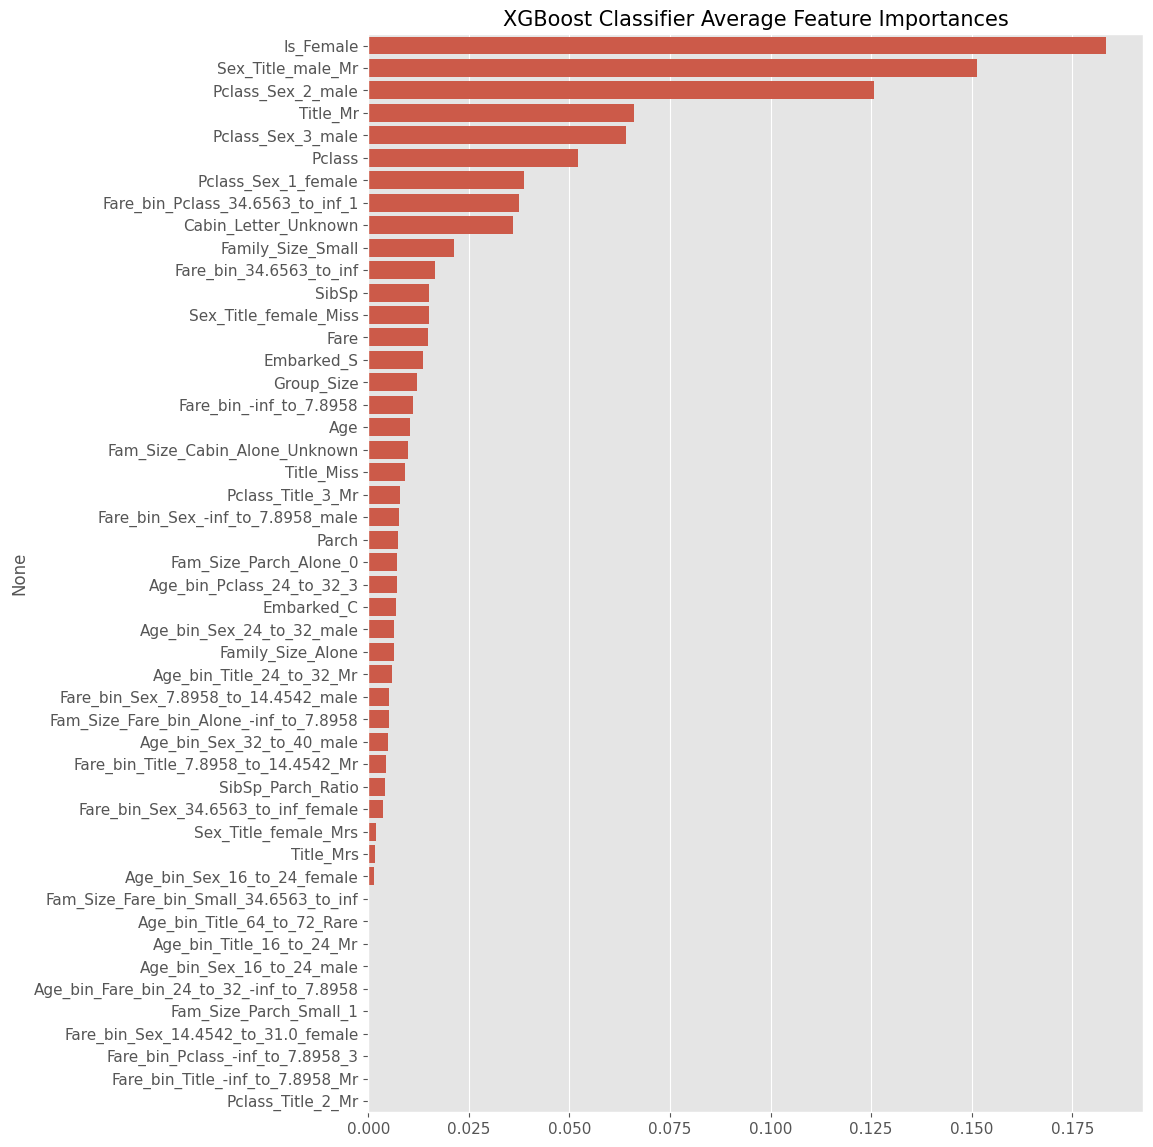

In [86]:
plt.figure(figsize=(10, int(len(feature_importances)/3.4)))
sns.barplot(x='Avg_Importance', y=feature_importances.index, data=feature_importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)
plt.title('XGBoost Classifier Average Feature Importances', size=15)
plt.show()

<h1 id="Thank_You"
     style="color: white;
            font-size: 28px;
            font-weight: bold;
            border-radius: 5px;
            background-color: #188193;
            border-bottom: 4px solid black;
            padding: 17px 0px 17px 30px;
            margin-top:20px">
    11. Thank You
    <a class="anchor-link"
       href="#Thank_You"
       target="_self"
       rel=" noreferrer nofollow">
        ¶
    </a>
</h1>

<p style="font-family: 'Caveat Brush', cursive; font-size: 24px; color: #188193">
    Thank you for taking the time to review this notebook. I hope you found it helpful. looking forward for any thoughts, feedback, or comments you may have, and would greatly appreciate an upvote if you found the content useful.
</p>

<p style="font-family: 'Caveat Brush', cursive; font-size: 25px; color: #188193; text-align: center; display: block; padding-right: 50px">
    Have a wonderful day!<br>
Wissam
</p>